<a href="https://colab.research.google.com/github/wangbxj1234/huazi/blob/main/paddleocr1103.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 准备

In [1]:
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/pgnet/e2e_server_pgnetA_infer.tar
!tar xf /content/e2e_server_pgnetA_infer.tar
!git clone https://github.com/PaddlePaddle/PaddleOCR
%cd PaddleOCR
!pip3 install -r requirements.txt
!pip install paddlepaddle -q

--2024-11-03 06:22:38--  https://paddleocr.bj.bcebos.com/dygraph_v2.0/pgnet/e2e_server_pgnetA_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 103.235.47.176, 2409:8c04:1001:1203:0:ff:b0bb:4f27
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|103.235.47.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195768320 (187M) [application/x-tar]
Saving to: ‘e2e_server_pgnetA_infer.tar’

e2e_server_pgnetA_i 100%[===================>] 186.70M  13.2MB/s    in 34s     

2024-11-03 06:23:14 (5.56 MB/s) - ‘e2e_server_pgnetA_infer.tar’ saved [195768320/195768320]

Cloning into 'PaddleOCR'...
remote: Enumerating objects: 58565, done.
remote: Counting objects: 100% (7635/7635), done.
remote: Compressing objects: 100% (1699/1699), done.
remote: Total 58565 (delta 6225), reused 7243 (delta 5934), pack-reused 50930 (from 1)
Receiving objects: 100% (58565/58565), 421.84 MiB | 23.77 MiB/s, done.
Resolving deltas: 100% (41923/41923), done.
U

## new and utility

In [2]:
# Copyright (c) 2020 PaddlePaddle Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import argparse
import os
import sys
import cv2
import numpy as np
import paddle
import PIL
from PIL import Image, ImageDraw, ImageFont
import math
from paddle import inference
import random
from ppocr.utils.logging import get_logger


def str2bool(v):
    return v.lower() in ("true", "yes", "t", "y", "1")


def str2int_tuple(v):
    return tuple([int(i.strip()) for i in v.split(",")])


def init_args():
    parser = argparse.ArgumentParser()
    # params for prediction engine
    parser.add_argument("--use_gpu", type=str2bool, default=True)
    parser.add_argument("--use_xpu", type=str2bool, default=False)
    parser.add_argument("--use_npu", type=str2bool, default=False)
    parser.add_argument("--use_mlu", type=str2bool, default=False)
    parser.add_argument("--ir_optim", type=str2bool, default=True)
    parser.add_argument("--use_tensorrt", type=str2bool, default=False)
    parser.add_argument("--min_subgraph_size", type=int, default=15)
    parser.add_argument("--precision", type=str, default="fp32")
    parser.add_argument("--gpu_mem", type=int, default=500)
    parser.add_argument("--gpu_id", type=int, default=0)

    # params for text detector
    parser.add_argument("--image_dir", type=str)
    parser.add_argument("--page_num", type=int, default=0)
    parser.add_argument("--det_algorithm", type=str, default="DB")
    parser.add_argument("--det_model_dir", type=str)
    parser.add_argument("--det_limit_side_len", type=float, default=960)
    parser.add_argument("--det_limit_type", type=str, default="max")
    parser.add_argument("--det_box_type", type=str, default="quad")

    # DB parmas
    parser.add_argument("--det_db_thresh", type=float, default=0.3)
    parser.add_argument("--det_db_box_thresh", type=float, default=0.6)
    parser.add_argument("--det_db_unclip_ratio", type=float, default=1.5)
    parser.add_argument("--max_batch_size", type=int, default=10)
    parser.add_argument("--use_dilation", type=str2bool, default=False)
    parser.add_argument("--det_db_score_mode", type=str, default="fast")

    # EAST parmas
    parser.add_argument("--det_east_score_thresh", type=float, default=0.8)
    parser.add_argument("--det_east_cover_thresh", type=float, default=0.1)
    parser.add_argument("--det_east_nms_thresh", type=float, default=0.2)

    # SAST parmas
    parser.add_argument("--det_sast_score_thresh", type=float, default=0.5)
    parser.add_argument("--det_sast_nms_thresh", type=float, default=0.2)

    # PSE parmas
    parser.add_argument("--det_pse_thresh", type=float, default=0)
    parser.add_argument("--det_pse_box_thresh", type=float, default=0.85)
    parser.add_argument("--det_pse_min_area", type=float, default=16)
    parser.add_argument("--det_pse_scale", type=int, default=1)

    # FCE parmas
    parser.add_argument("--scales", type=list, default=[8, 16, 32])
    parser.add_argument("--alpha", type=float, default=1.0)
    parser.add_argument("--beta", type=float, default=1.0)
    parser.add_argument("--fourier_degree", type=int, default=5)

    # params for text recognizer
    parser.add_argument("--rec_algorithm", type=str, default="SVTR_LCNet")
    parser.add_argument("--rec_model_dir", type=str)
    parser.add_argument("--rec_image_inverse", type=str2bool, default=True)
    parser.add_argument("--rec_image_shape", type=str, default="3, 48, 320")
    parser.add_argument("--rec_batch_num", type=int, default=6)
    parser.add_argument("--max_text_length", type=int, default=25)
    parser.add_argument(
        "--rec_char_dict_path", type=str, default="./ppocr/utils/ppocr_keys_v1.txt"
    )
    parser.add_argument("--use_space_char", type=str2bool, default=True)
    parser.add_argument("--vis_font_path", type=str, default="./doc/fonts/simfang.ttf")
    parser.add_argument("--drop_score", type=float, default=0.5)

    # params for e2e
    parser.add_argument("--e2e_algorithm", type=str, default="PGNet")
    parser.add_argument("--e2e_model_dir", type=str)
    parser.add_argument("--e2e_limit_side_len", type=float, default=768)
    parser.add_argument("--e2e_limit_type", type=str, default="max")

    # PGNet parmas
    parser.add_argument("--e2e_pgnet_score_thresh", type=float, default=0.5)
    parser.add_argument(
        "--e2e_char_dict_path", type=str, default="./ppocr/utils/ic15_dict.txt"
    )
    parser.add_argument("--e2e_pgnet_valid_set", type=str, default="totaltext")
    parser.add_argument("--e2e_pgnet_mode", type=str, default="fast")

    # params for text classifier
    parser.add_argument("--use_angle_cls", type=str2bool, default=False)
    parser.add_argument("--cls_model_dir", type=str)
    parser.add_argument("--cls_image_shape", type=str, default="3, 48, 192")
    parser.add_argument("--label_list", type=list, default=["0", "180"])
    parser.add_argument("--cls_batch_num", type=int, default=6)
    parser.add_argument("--cls_thresh", type=float, default=0.9)

    parser.add_argument("--enable_mkldnn", type=str2bool, default=False)
    parser.add_argument("--cpu_threads", type=int, default=10)
    parser.add_argument("--use_pdserving", type=str2bool, default=False)
    parser.add_argument("--warmup", type=str2bool, default=False)

    # SR parmas
    parser.add_argument("--sr_model_dir", type=str)
    parser.add_argument("--sr_image_shape", type=str, default="3, 32, 128")
    parser.add_argument("--sr_batch_num", type=int, default=1)

    #
    parser.add_argument("--draw_img_save_dir", type=str, default="./inference_results")
    parser.add_argument("--save_crop_res", type=str2bool, default=False)
    parser.add_argument("--crop_res_save_dir", type=str, default="./output")

    # multi-process
    parser.add_argument("--use_mp", type=str2bool, default=False)
    parser.add_argument("--total_process_num", type=int, default=1)
    parser.add_argument("--process_id", type=int, default=0)

    parser.add_argument("--benchmark", type=str2bool, default=False)
    parser.add_argument("--save_log_path", type=str, default="./log_output/")

    parser.add_argument("--show_log", type=str2bool, default=True)
    parser.add_argument("--use_onnx", type=str2bool, default=False)

    # extended function
    parser.add_argument(
        "--return_word_box",
        type=str2bool,
        default=False,
        help="Whether return the bbox of each word (split by space) or chinese character. Only used in ppstructure for layout recovery",
    )

    return parser


def parse_args():
    parser = init_args()
    return parser.parse_args()


def create_predictor(args, logger):

    model_dir = args.e2e_model_dir

    if model_dir is None:
        logger.info("not find {} model file path {}".format(mode, model_dir))
        sys.exit(0)
    if args.use_onnx:
        import onnxruntime as ort

        model_file_path = model_dir
        if not os.path.exists(model_file_path):
            raise ValueError("not find model file path {}".format(model_file_path))
        if args.use_gpu:
            sess = ort.InferenceSession(
                model_file_path,
                providers=[
                    (
                        "CUDAExecutionProvider",
                        {"device_id": args.gpu_id, "cudnn_conv_algo_search": "DEFAULT"},
                    )
                ],
            )
        else:
            sess = ort.InferenceSession(
                model_file_path, providers=["CPUExecutionProvider"]
            )
        return sess, sess.get_inputs()[0], None, None

    else:
        file_names = ["model", "inference"]
        for file_name in file_names:
            model_file_path = "{}/{}.pdmodel".format(model_dir, file_name)
            params_file_path = "{}/{}.pdiparams".format(model_dir, file_name)
            if os.path.exists(model_file_path) and os.path.exists(params_file_path):
                break
        if not os.path.exists(model_file_path):
            raise ValueError(
                "not find model.pdmodel or inference.pdmodel in {}".format(model_dir)
            )
        if not os.path.exists(params_file_path):
            raise ValueError(
                "not find model.pdiparams or inference.pdiparams in {}".format(
                    model_dir
                )
            )

        config = inference.Config(model_file_path, params_file_path)

        if hasattr(args, "precision"):
            if args.precision == "fp16" and args.use_tensorrt:
                precision = inference.PrecisionType.Half
            elif args.precision == "int8":
                precision = inference.PrecisionType.Int8
            else:
                precision = inference.PrecisionType.Float32
        else:
            precision = inference.PrecisionType.Float32

        if args.use_gpu:
            gpu_id = get_infer_gpuid()
            if gpu_id is None:
                logger.warning(
                    "GPU is not found in current device by nvidia-smi. Please check your device or ignore it if run on jetson."
                )
            config.enable_use_gpu(args.gpu_mem, args.gpu_id)
            if args.use_tensorrt:
                config.enable_tensorrt_engine(
                    workspace_size=1 << 30,
                    precision_mode=precision,
                    max_batch_size=args.max_batch_size,
                    min_subgraph_size=args.min_subgraph_size,  # skip the minmum trt subgraph
                    use_calib_mode=False,
                )

                # collect shape
                trt_shape_f = os.path.join(model_dir, f"{mode}_trt_dynamic_shape.txt")

                if not os.path.exists(trt_shape_f):
                    config.collect_shape_range_info(trt_shape_f)
                    logger.info(f"collect dynamic shape info into : {trt_shape_f}")
                try:
                    config.enable_tuned_tensorrt_dynamic_shape(trt_shape_f, True)
                except Exception as E:
                    logger.info(E)
                    logger.info("Please keep your paddlepaddle-gpu >= 2.3.0!")

        else:
            config.disable_gpu()
            if args.enable_mkldnn:
                # cache 10 different shapes for mkldnn to avoid memory leak
                config.set_mkldnn_cache_capacity(10)
                config.enable_mkldnn()
                if args.precision == "fp16":
                    config.enable_mkldnn_bfloat16()
                if hasattr(args, "cpu_threads"):
                    config.set_cpu_math_library_num_threads(args.cpu_threads)
                else:
                    # default cpu threads as 10
                    config.set_cpu_math_library_num_threads(10)
        # enable memory optim
        config.enable_memory_optim()
        config.disable_glog_info()
        config.delete_pass("conv_transpose_eltwiseadd_bn_fuse_pass")
        config.delete_pass("matmul_transpose_reshape_fuse_pass")

        config.switch_use_feed_fetch_ops(False)
        config.switch_ir_optim(True)

        # create predictor
        predictor = inference.create_predictor(config)
        input_names = predictor.get_input_names()

        for name in input_names:
                input_tensor = predictor.get_input_handle(name)
        output_tensors = get_output_tensors(args, predictor)
        return predictor, input_tensor, output_tensors, config


def get_output_tensors(args, predictor):
    output_names = predictor.get_output_names()
    output_tensors = []

    for output_name in output_names:
            output_tensor = predictor.get_output_handle(output_name)
            output_tensors.append(output_tensor)
    return output_tensors


def get_infer_gpuid():
    """
    Get the GPU ID to be used for inference.

    Returns:
        int: The GPU ID to be used for inference.
    """
    logger = get_logger()
    if not paddle.device.is_compiled_with_rocm:
        gpu_id_str = os.environ.get("CUDA_VISIBLE_DEVICES", "0")
    else:
        gpu_id_str = os.environ.get("HIP_VISIBLE_DEVICES", "0")

    gpu_ids = gpu_id_str.split(",")
    logger.warning(
        "The first GPU is used for inference by default, GPU ID: {}".format(gpu_ids[0])
    )
    return int(gpu_ids[0])


def draw_e2e_res(dt_boxes, strs, img_path):
    src_im = cv2.imread(img_path)
    for box, str in zip(dt_boxes, strs):
        box = box.astype(np.int32).reshape((-1, 1, 2))
        cv2.polylines(src_im, [box], True, color=(255, 255, 0), thickness=2)
        cv2.putText(
            src_im,
            str,
            org=(int(box[0, 0, 0]), int(box[0, 0, 1])),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=0.7,
            color=(0, 255, 0),
            thickness=1,
        )
    return src_im


def draw_text_det_res(dt_boxes, img):
    for box in dt_boxes:
        box = np.array(box).astype(np.int32).reshape(-1, 2)
        cv2.polylines(img, [box], True, color=(255, 255, 0), thickness=2)
    return img


def resize_img(img, input_size=600):
    """
    resize img and limit the longest side of the image to input_size
    """
    img = np.array(img)
    im_shape = img.shape
    im_size_max = np.max(im_shape[0:2])
    im_scale = float(input_size) / float(im_size_max)
    img = cv2.resize(img, None, None, fx=im_scale, fy=im_scale)
    return img


def draw_ocr(
    image,
    boxes,
    txts=None,
    scores=None,
    drop_score=0.5,
    font_path="./doc/fonts/simfang.ttf",
):
    """
    Visualize the results of OCR detection and recognition
    args:
        image(Image|array): RGB image
        boxes(list): boxes with shape(N, 4, 2)
        txts(list): the texts
        scores(list): txxs corresponding scores
        drop_score(float): only scores greater than drop_threshold will be visualized
        font_path: the path of font which is used to draw text
    return(array):
        the visualized img
    """
    if scores is None:
        scores = [1] * len(boxes)
    box_num = len(boxes)
    for i in range(box_num):
        if scores is not None and (scores[i] < drop_score or math.isnan(scores[i])):
            continue
        box = np.reshape(np.array(boxes[i]), [-1, 1, 2]).astype(np.int64)
        image = cv2.polylines(np.array(image), [box], True, (255, 0, 0), 2)
    if txts is not None:
        img = np.array(resize_img(image, input_size=600))
        txt_img = text_visual(
            txts,
            scores,
            img_h=img.shape[0],
            img_w=600,
            threshold=drop_score,
            font_path=font_path,
        )
        img = np.concatenate([np.array(img), np.array(txt_img)], axis=1)
        return img
    return image


def draw_ocr_box_txt(
    image,
    boxes,
    txts=None,
    scores=None,
    drop_score=0.5,
    font_path="./doc/fonts/simfang.ttf",
):
    h, w = image.height, image.width
    img_left = image.copy()
    img_right = np.ones((h, w, 3), dtype=np.uint8) * 255
    random.seed(0)

    draw_left = ImageDraw.Draw(img_left)
    if txts is None or len(txts) != len(boxes):
        txts = [None] * len(boxes)
    for idx, (box, txt) in enumerate(zip(boxes, txts)):
        if scores is not None and scores[idx] < drop_score:
            continue
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        draw_left.polygon(box, fill=color)
        img_right_text = draw_box_txt_fine((w, h), box, txt, font_path)
        pts = np.array(box, np.int32).reshape((-1, 1, 2))
        cv2.polylines(img_right_text, [pts], True, color, 1)
        img_right = cv2.bitwise_and(img_right, img_right_text)
    img_left = Image.blend(image, img_left, 0.5)
    img_show = Image.new("RGB", (w * 2, h), (255, 255, 255))
    img_show.paste(img_left, (0, 0, w, h))
    img_show.paste(Image.fromarray(img_right), (w, 0, w * 2, h))
    return np.array(img_show)


def draw_box_txt_fine(img_size, box, txt, font_path="./doc/fonts/simfang.ttf"):
    box_height = int(
        math.sqrt((box[0][0] - box[3][0]) ** 2 + (box[0][1] - box[3][1]) ** 2)
    )
    box_width = int(
        math.sqrt((box[0][0] - box[1][0]) ** 2 + (box[0][1] - box[1][1]) ** 2)
    )

    if box_height > 2 * box_width and box_height > 30:
        img_text = Image.new("RGB", (box_height, box_width), (255, 255, 255))
        draw_text = ImageDraw.Draw(img_text)
        if txt:
            font = create_font(txt, (box_height, box_width), font_path)
            draw_text.text([0, 0], txt, fill=(0, 0, 0), font=font)
        img_text = img_text.transpose(Image.ROTATE_270)
    else:
        img_text = Image.new("RGB", (box_width, box_height), (255, 255, 255))
        draw_text = ImageDraw.Draw(img_text)
        if txt:
            font = create_font(txt, (box_width, box_height), font_path)
            draw_text.text([0, 0], txt, fill=(0, 0, 0), font=font)

    pts1 = np.float32(
        [[0, 0], [box_width, 0], [box_width, box_height], [0, box_height]]
    )
    pts2 = np.array(box, dtype=np.float32)
    M = cv2.getPerspectiveTransform(pts1, pts2)

    img_text = np.array(img_text, dtype=np.uint8)
    img_right_text = cv2.warpPerspective(
        img_text,
        M,
        img_size,
        flags=cv2.INTER_NEAREST,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(255, 255, 255),
    )
    return img_right_text


def create_font(txt, sz, font_path="./doc/fonts/simfang.ttf"):
    font_size = int(sz[1] * 0.99)
    font = ImageFont.truetype(font_path, font_size, encoding="utf-8")
    if int(PIL.__version__.split(".")[0]) < 10:
        length = font.getsize(txt)[0]
    else:
        length = font.getlength(txt)

    if length > sz[0]:
        font_size = int(font_size * sz[0] / length)
        font = ImageFont.truetype(font_path, font_size, encoding="utf-8")
    return font


def str_count(s):
    """
    Count the number of Chinese characters,
    a single English character and a single number
    equal to half the length of Chinese characters.
    args:
        s(string): the input of string
    return(int):
        the number of Chinese characters
    """
    import string

    count_zh = count_pu = 0
    s_len = len(s)
    en_dg_count = 0
    for c in s:
        if c in string.ascii_letters or c.isdigit() or c.isspace():
            en_dg_count += 1
        elif c.isalpha():
            count_zh += 1
        else:
            count_pu += 1
    return s_len - math.ceil(en_dg_count / 2)


def text_visual(
    texts, scores, img_h=400, img_w=600, threshold=0.0, font_path="./doc/simfang.ttf"
):
    """
    create new blank img and draw txt on it
    args:
        texts(list): the text will be draw
        scores(list|None): corresponding score of each txt
        img_h(int): the height of blank img
        img_w(int): the width of blank img
        font_path: the path of font which is used to draw text
    return(array):
    """
    if scores is not None:
        assert len(texts) == len(
            scores
        ), "The number of txts and corresponding scores must match"

    def create_blank_img():
        blank_img = np.ones(shape=[img_h, img_w], dtype=np.int8) * 255
        blank_img[:, img_w - 1 :] = 0
        blank_img = Image.fromarray(blank_img).convert("RGB")
        draw_txt = ImageDraw.Draw(blank_img)
        return blank_img, draw_txt

    blank_img, draw_txt = create_blank_img()

    font_size = 20
    txt_color = (0, 0, 0)
    font = ImageFont.truetype(font_path, font_size, encoding="utf-8")

    gap = font_size + 5
    txt_img_list = []
    count, index = 1, 0
    for idx, txt in enumerate(texts):
        index += 1
        if scores[idx] < threshold or math.isnan(scores[idx]):
            index -= 1
            continue
        first_line = True
        while str_count(txt) >= img_w // font_size - 4:
            tmp = txt
            txt = tmp[: img_w // font_size - 4]
            if first_line:
                new_txt = str(index) + ": " + txt
                first_line = False
            else:
                new_txt = "    " + txt
            draw_txt.text((0, gap * count), new_txt, txt_color, font=font)
            txt = tmp[img_w // font_size - 4 :]
            if count >= img_h // gap - 1:
                txt_img_list.append(np.array(blank_img))
                blank_img, draw_txt = create_blank_img()
                count = 0
            count += 1
        if first_line:
            new_txt = str(index) + ": " + txt + "   " + "%.3f" % (scores[idx])
        else:
            new_txt = "  " + txt + "  " + "%.3f" % (scores[idx])
        draw_txt.text((0, gap * count), new_txt, txt_color, font=font)
        # whether add new blank img or not
        if count >= img_h // gap - 1 and idx + 1 < len(texts):
            txt_img_list.append(np.array(blank_img))
            blank_img, draw_txt = create_blank_img()
            count = 0
        count += 1
    txt_img_list.append(np.array(blank_img))
    if len(txt_img_list) == 1:
        blank_img = np.array(txt_img_list[0])
    else:
        blank_img = np.concatenate(txt_img_list, axis=1)
    return np.array(blank_img)


def base64_to_cv2(b64str):
    import base64

    data = base64.b64decode(b64str.encode("utf8"))
    data = np.frombuffer(data, np.uint8)
    data = cv2.imdecode(data, cv2.IMREAD_COLOR)
    return data


def draw_boxes(image, boxes, scores=None, drop_score=0.5):
    if scores is None:
        scores = [1] * len(boxes)
    for box, score in zip(boxes, scores):
        if score < drop_score:
            continue
        box = np.reshape(np.array(box), [-1, 1, 2]).astype(np.int64)
        image = cv2.polylines(np.array(image), [box], True, (255, 0, 0), 2)
    return image


def get_rotate_crop_image(img, points):
    """
    img_height, img_width = img.shape[0:2]
    left = int(np.min(points[:, 0]))
    right = int(np.max(points[:, 0]))
    top = int(np.min(points[:, 1]))
    bottom = int(np.max(points[:, 1]))
    img_crop = img[top:bottom, left:right, :].copy()
    points[:, 0] = points[:, 0] - left
    points[:, 1] = points[:, 1] - top
    """
    assert len(points) == 4, "shape of points must be 4*2"
    img_crop_width = int(
        max(
            np.linalg.norm(points[0] - points[1]), np.linalg.norm(points[2] - points[3])
        )
    )
    img_crop_height = int(
        max(
            np.linalg.norm(points[0] - points[3]), np.linalg.norm(points[1] - points[2])
        )
    )
    pts_std = np.float32(
        [
            [0, 0],
            [img_crop_width, 0],
            [img_crop_width, img_crop_height],
            [0, img_crop_height],
        ]
    )
    M = cv2.getPerspectiveTransform(points, pts_std)
    dst_img = cv2.warpPerspective(
        img,
        M,
        (img_crop_width, img_crop_height),
        borderMode=cv2.BORDER_REPLICATE,
        flags=cv2.INTER_CUBIC,
    )
    dst_img_height, dst_img_width = dst_img.shape[0:2]
    if dst_img_height * 1.0 / dst_img_width >= 1.5:
        dst_img = np.rot90(dst_img)
    return dst_img


def get_minarea_rect_crop(img, points):
    bounding_box = cv2.minAreaRect(np.array(points).astype(np.int32))
    points = sorted(list(cv2.boxPoints(bounding_box)), key=lambda x: x[0])

    index_a, index_b, index_c, index_d = 0, 1, 2, 3
    if points[1][1] > points[0][1]:
        index_a = 0
        index_d = 1
    else:
        index_a = 1
        index_d = 0
    if points[3][1] > points[2][1]:
        index_b = 2
        index_c = 3
    else:
        index_b = 3
        index_c = 2

    box = [points[index_a], points[index_b], points[index_c], points[index_d]]
    crop_img = get_rotate_crop_image(img, np.array(box))
    return crop_img


def slice_generator(image, horizontal_stride, vertical_stride, maximum_slices=500):
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    image_h, image_w = image.shape[:2]
    vertical_num_slices = (image_h + vertical_stride - 1) // vertical_stride
    horizontal_num_slices = (image_w + horizontal_stride - 1) // horizontal_stride

    assert (
        vertical_num_slices > 0
    ), f"Invalid number ({vertical_num_slices}) of vertical slices"

    assert (
        horizontal_num_slices > 0
    ), f"Invalid number ({horizontal_num_slices}) of horizontal slices"

    if vertical_num_slices >= maximum_slices:
        recommended_vertical_stride = max(1, image_h // maximum_slices) + 1
        assert (
            False
        ), f"Too computationally expensive with {vertical_num_slices} slices, try a higher vertical stride (recommended minimum: {recommended_vertical_stride})"

    if horizontal_num_slices >= maximum_slices:
        recommended_horizontal_stride = max(1, image_w // maximum_slices) + 1
        assert (
            False
        ), f"Too computationally expensive with {horizontal_num_slices} slices, try a higher horizontal stride (recommended minimum: {recommended_horizontal_stride})"

    for v_slice_idx in range(vertical_num_slices):
        v_start = max(0, (v_slice_idx * vertical_stride))
        v_end = min(((v_slice_idx + 1) * vertical_stride), image_h)
        vertical_slice = image[v_start:v_end, :]
        for h_slice_idx in range(horizontal_num_slices):
            h_start = max(0, (h_slice_idx * horizontal_stride))
            h_end = min(((h_slice_idx + 1) * horizontal_stride), image_w)
            horizontal_slice = vertical_slice[:, h_start:h_end]

            yield (horizontal_slice, v_start, h_start)


def calculate_box_extents(box):
    min_x = box[0][0]
    max_x = box[1][0]
    min_y = box[0][1]
    max_y = box[2][1]
    return min_x, max_x, min_y, max_y


def merge_boxes(box1, box2, x_threshold, y_threshold):
    min_x1, max_x1, min_y1, max_y1 = calculate_box_extents(box1)
    min_x2, max_x2, min_y2, max_y2 = calculate_box_extents(box2)

    if (
        abs(min_y1 - min_y2) <= y_threshold
        and abs(max_y1 - max_y2) <= y_threshold
        and abs(max_x1 - min_x2) <= x_threshold
    ):
        new_xmin = min(min_x1, min_x2)
        new_xmax = max(max_x1, max_x2)
        new_ymin = min(min_y1, min_y2)
        new_ymax = max(max_y1, max_y2)
        return [
            [new_xmin, new_ymin],
            [new_xmax, new_ymin],
            [new_xmax, new_ymax],
            [new_xmin, new_ymax],
        ]
    else:
        return None


def merge_fragmented(boxes, x_threshold=10, y_threshold=10):
    merged_boxes = []
    visited = set()

    for i, box1 in enumerate(boxes):
        if i in visited:
            continue

        merged_box = [point[:] for point in box1]

        for j, box2 in enumerate(boxes[i + 1 :], start=i + 1):
            if j not in visited:
                merged_result = merge_boxes(
                    merged_box, box2, x_threshold=x_threshold, y_threshold=y_threshold
                )
                if merged_result:
                    merged_box = merged_result
                    visited.add(j)

        merged_boxes.append(merged_box)

    if len(merged_boxes) == len(boxes):
        return np.array(merged_boxes)
    else:
        return merge_fragmented(merged_boxes, x_threshold, y_threshold)


def check_gpu(use_gpu):
    if use_gpu and (
        not paddle.is_compiled_with_cuda() or paddle.device.get_device() == "cpu"
    ):
        use_gpu = False
    return use_gpu


if __name__ == "__main__":
    pass


In [3]:
import cv2
import numpy as np
import time
import sys

# import tools.infer.utility as utility
from ppocr.utils.logging import get_logger
from ppocr.utils.utility import get_image_file_list, check_and_read
from ppocr.data import create_operators, transform
from ppocr.postprocess import build_post_process
import argparse
logger = get_logger()


class TextE2E(object):
    def __init__(self, args):
        self.args = args
        self.e2e_algorithm = args.e2e_algorithm
        self.use_onnx = args.use_onnx
        pre_process_list = [
            {"E2EResizeForTest": {}},
            {
                "NormalizeImage": {
                    "std": [0.229, 0.224, 0.225],
                    "mean": [0.485, 0.456, 0.406],
                    "scale": "1./255.",
                    "order": "hwc",
                }
            },
            {"ToCHWImage": None},
            {"KeepKeys": {"keep_keys": ["image", "shape"]}},
        ]
        postprocess_params = {}
        if self.e2e_algorithm == "PGNet":
            pre_process_list[0] = {
                "E2EResizeForTest": {
                    "max_side_len": args.e2e_limit_side_len,
                    "valid_set": "totaltext",
                }
            }
            postprocess_params["name"] = "PGPostProcess"
            postprocess_params["score_thresh"] = args.e2e_pgnet_score_thresh
            postprocess_params["character_dict_path"] = args.e2e_char_dict_path
            postprocess_params["valid_set"] = args.e2e_pgnet_valid_set
            postprocess_params["mode"] = args.e2e_pgnet_mode
        else:
            logger.info("unknown e2e_algorithm:{}".format(self.e2e_algorithm))
            sys.exit(0)

        self.preprocess_op = create_operators(pre_process_list)
        self.postprocess_op = build_post_process(postprocess_params)
        (
            self.predictor,
            self.input_tensor,
            self.output_tensors,
            _,
        ) = create_predictor(
            args, logger
        )  # paddle.jit.load(args.det_model_dir)
        # self.predictor.eval()

    def clip_det_res(self, points, img_height, img_width):
        for pno in range(points.shape[0]):
            points[pno, 0] = int(min(max(points[pno, 0], 0), img_width - 1))
            points[pno, 1] = int(min(max(points[pno, 1], 0), img_height - 1))
        return points

    def filter_tag_det_res_only_clip(self, dt_boxes, image_shape):
        img_height, img_width = image_shape[0:2]
        dt_boxes_new = []
        for box in dt_boxes:
            box = self.clip_det_res(box, img_height, img_width)
            dt_boxes_new.append(box)
        dt_boxes = np.array(dt_boxes_new)
        return dt_boxes

    def __call__(self, img):
        ori_im = img.copy()
        data = {"image": img}
        data = transform(data, self.preprocess_op)
        img, shape_list = data
        if img is None:
            return None, 0
        img = np.expand_dims(img, axis=0)
        shape_list = np.expand_dims(shape_list, axis=0)
        img = img.copy()
        starttime = time.time()

        if self.use_onnx:
            input_dict = {}
            input_dict[self.input_tensor.name] = img
            outputs = self.predictor.run(self.output_tensors, input_dict)
            preds = {}
            preds["f_border"] = outputs[0]
            preds["f_char"] = outputs[1]
            preds["f_direction"] = outputs[2]
            preds["f_score"] = outputs[3]
        else:
            self.input_tensor.copy_from_cpu(img)
            self.predictor.run()
            outputs = []
            for output_tensor in self.output_tensors:
                output = output_tensor.copy_to_cpu()
                outputs.append(output)

            preds = {}
            if self.e2e_algorithm == "PGNet":
                preds["f_border"] = outputs[0]
                preds["f_char"] = outputs[1]
                preds["f_direction"] = outputs[2]
                preds["f_score"] = outputs[3]
            else:
                raise NotImplementedError
        post_result = self.postprocess_op(preds, shape_list)
        points, strs = post_result["points"], post_result["texts"]
        dt_boxes = self.filter_tag_det_res_only_clip(points, ori_im.shape)
        elapse = time.time() - starttime
        return dt_boxes, strs, elapse

# from toy1 import get_inner_config
#
# if __name__ == "__main__":
#     config = get_inner_config()
#
#
#     image_file_list = get_image_file_list('/home/w84376787/PaddleOCR-main/doc/imgs_en/img_10.jpg')
#     text_detector = TextE2E(config)
#     count = 0
#     total_time = 0
#     draw_img_save = "./inference_results"
#     # if not os.path.exists(draw_img_save):
#     #     os.makedirs(draw_img_save)
#     for image_file in image_file_list:
#         img, flag, _ = check_and_read(image_file)
#         if not flag:
#             img = cv2.imread(image_file)
#         if img is None:
#             logger.info("error in loading image:{}".format(image_file))
#             continue
#         points, strs, elapse = text_detector(img)
#
#         print(points, strs, elapse)



# 成功加载 ocr model

In [4]:
#from new import TextE2E   colab里不用这样
import torch.nn as nn
from ppocr.utils.logging import get_logger
from ppocr.utils.utility import get_image_file_list, check_and_read
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont



class Config:
    def __init__(self, config_dict):
        self.__dict__.update(config_dict)


def get_inner_config():
    config = {
        # Prediction engine params
        "use_gpu": True,
        "use_xpu": False,
        "use_npu": False,
        "use_mlu": False,
        "ir_optim": True,
        "use_tensorrt": False,
        "min_subgraph_size": 15,
        "precision": "fp32",
        "gpu_mem": 500,
        "gpu_id": 0,

        # Text detector params
        "image_dir": None,
        "page_num": 0,
        "det_algorithm": "DB",
        "det_model_dir": None,
        "det_limit_side_len": 960,
        "det_limit_type": "max",
        "det_box_type": "quad",

        # DB params
        "det_db_thresh": 0.3,
        "det_db_box_thresh": 0.6,
        "det_db_unclip_ratio": 1.5,
        "max_batch_size": 10,
        "use_dilation": False,
        "det_db_score_mode": "fast",

        # EAST params
        "det_east_score_thresh": 0.8,
        "det_east_cover_thresh": 0.1,
        "det_east_nms_thresh": 0.2,

        # SAST params
        "det_sast_score_thresh": 0.5,
        "det_sast_nms_thresh": 0.2,

        # PSE params
        "det_pse_thresh": 0,
        "det_pse_box_thresh": 0.85,
        "det_pse_min_area": 16,
        "det_pse_scale": 1,

        # FCE params
        "scales": [8, 16, 32],
        "alpha": 1.0,
        "beta": 1.0,
        "fourier_degree": 5,

        # Text recognizer params
        "rec_algorithm": "SVTR_LCNet",
        "rec_model_dir": None,
        "rec_image_inverse": True,
        "rec_image_shape": "3, 48, 320",
        "rec_batch_num": 6,
        "max_text_length": 25,
        "rec_char_dict_path": "./ppocr/utils/ppocr_keys_v1.txt",
        "use_space_char": True,
        "vis_font_path": "./doc/fonts/simfang.ttf",
        "drop_score": 0.5,

        # E2E params
        "e2e_algorithm": "PGNet",
        "e2e_model_dir": '/content/e2e_server_pgnetA_infer',
        "e2e_limit_side_len": 768,
        "e2e_limit_type": "max",

        # PGNet params
        "e2e_pgnet_score_thresh": 0.5,
        "e2e_char_dict_path": "./ppocr/utils/ic15_dict.txt",
        "e2e_pgnet_valid_set": "totaltext",
        "e2e_pgnet_mode": "fast",

        # Text classifier params
        "use_angle_cls": False,
        "cls_model_dir": None,
        "cls_image_shape": "3, 48, 192",
        "label_list": ["0", "180"],
        "cls_batch_num": 6,
        "cls_thresh": 0.9,

        # Other settings
        "enable_mkldnn": False,
        "cpu_threads": 10,
        "use_pdserving": False,
        "warmup": False,

        # SR params
        "sr_model_dir": None,
        "sr_image_shape": "3, 32, 128",
        "sr_batch_num": 1,

        # Save directories
        "draw_img_save_dir": "./inference_results",
        "save_crop_res": False,
        "crop_res_save_dir": "./output",

        # Multi-process params
        "use_mp": False,
        "total_process_num": 1,
        "process_id": 0,

        # Benchmarking
        "benchmark": False,
        "save_log_path": "./log_output/",
        "show_log": True,
        "use_onnx": False,

        # Extended function
        "return_word_box": False,
    }

    return Config(config)


logger = get_logger()

def OCR_E2E(img):
    config = get_inner_config()
    text_detector = TextE2E(config)
    img = cv2.imread(img)
    points, strs, _ = text_detector(img)
    #print(points, strs)
    return points, strs





[2024/11/03 06:26:00] ppocr WARNING: The first GPU is used for inference by default, GPU ID: 0


# 模型输出示例图片的检测框位置和文本内容

In [6]:
points, strs = OCR_E2E('/content/PaddleOCR/doc/imgs_en/img623.jpg')
points, strs

[2024/11/03 06:28:50] ppocr WARNING: The first GPU is used for inference by default, GPU ID: 0


(array([[[157., 256.],
         [165., 270.],
         [170., 281.],
         [175., 292.],
         [181., 302.],
         [194., 323.],
         [179., 336.],
         [163., 312.],
         [157., 301.],
         [150., 287.],
         [146., 276.],
         [142., 261.]],
 
        [[195., 324.],
         [204., 334.],
         [212., 343.],
         [219., 352.],
         [227., 359.],
         [236., 366.],
         [229., 384.],
         [218., 373.],
         [208., 365.],
         [198., 356.],
         [191., 347.],
         [182., 337.]],
 
        [[468., 381.],
         [476., 370.],
         [479., 363.],
         [482., 354.],
         [486., 346.],
         [492., 329.],
         [510., 337.],
         [506., 355.],
         [501., 364.],
         [496., 374.],
         [491., 382.],
         [482., 396.]],
 
        [[318., 342.],
         [325., 343.],
         [332., 345.],
         [338., 347.],
         [343., 347.],
         [356., 349.],
         [357., 359.],
  

# 利用输出文本的位置和内容信息做出模型效果的可视化。

## 可视化脚本准备

In [7]:
import cv2
import numpy as np

def draw_text_in_box(dt_box, text, src_im):
    # 将点转换为浮点型
    dt_box = np.array(dt_box, dtype=np.float32)

    # 计算最小外接矩形
    rect = cv2.minAreaRect(dt_box)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # 获取旋转角度并直接使用反向角度进行水平对齐
    center, size, _ = rect



    # 获取四个顶点的坐标
    (x0, y0), (x1, y1), (x2, y2), (x3, y3) = box

    # 计算两个相邻顶点之间的距离，区分长边和短边
    d01 = np.sqrt((x1 - x0)**2 + (y1 - y0)**2)
    d12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # 确定长边的两个顶点
    if d01 > d12:
        long_edge_start = (x0, y0)
        long_edge_end = (x1, y1)
    else:
        long_edge_start = (x1, y1)
        long_edge_end = (x2, y2)

    # 计算长边的角度
    angle = np.arctan2(long_edge_end[1] - long_edge_start[1], long_edge_end[0] - long_edge_start[0])
    angle = np.degrees(angle)
    print(f"Rotation Angle: {angle}")

    # 使用角度进行逆向旋转，使文本框水平
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 创建黑色背景图像
    black_image = np.zeros_like(src_im)

    # 设置初始字体大小和文本属性
    font_scale = 1.0
    font_face = cv2.FONT_HERSHEY_COMPLEX
    thickness = 1

    # 计算文本的尺寸
    (text_width, text_height), baseline = cv2.getTextSize(text, font_face, font_scale, thickness)

    # 调整字体大小以适合矩形框
    if d01 > d12:
        box_width, box_height = d01, d12
    else:
        box_width, box_height = d12, d01

    while text_width > box_width or text_height > box_height:
        font_scale -= 0.1
        (text_width, text_height), baseline = cv2.getTextSize(text, font_face, font_scale, thickness)

    # 计算文本的位置，使文本在旋转前居中
    text_x = int(center[0] - text_width / 2)
    text_y = int(center[1] + text_height / 2)

    # 在黑色背景上绘制文本
    cv2.putText(
        black_image,
        text,
        (text_x, text_y),
        font_face,
        font_scale,
        color=(0, 255, 0),
        thickness=thickness
    )

    # 将文本区域旋转回来
    rotation_matrix2 = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated_text = cv2.warpAffine(black_image, rotation_matrix2, src_im.shape[1::-1], flags=cv2.INTER_LINEAR)

    return rotated_text

def draw_e2e_res(dt_boxes, strs, img_path):
    # 读取原始图像
    src_im = cv2.imread(img_path)

    # 确保图像成功读取
    if src_im is None:
        print(f"Error: Could not read image from {img_path}")
        return None

    # 创建黑色背景图像
    black_image = np.zeros_like(src_im)

    # 遍历每个 dt_box 和对应的文本
    for box, text in zip(dt_boxes, strs):
          # 根据文本长度调整大小写
        # if len(text) < 12:
        # # 保持小写
        #   modified_text = text.upper()
        # else:
        # # 改成大写
        #   modified_text = text.lower()

        # 调用绘制文本的函数并叠加到黑色背景图上
       # rotated_text_image = draw_text_in_box(box, modified_text, src_im)
        rotated_text_image = draw_text_in_box(box, text, src_im)
        black_image = np.maximum(black_image, rotated_text_image)

    return black_image

# 示例调用
# points, strs = OCR_E2E('/path/to/image.jpg')
# result_image = draw_e2e_res(points, strs, '/path/to/image.jpg')

# # 示例调用
# points, strs = OCR_E2E('/content/PaddleOCR/doc/imgs_en/img623.jpg')
# result_image = draw_e2e_res(points, strs, '/content/PaddleOCR/doc/imgs_en/img623.jpg')


## 可视化效果

array([[[241, 239, 239],
        [129, 127, 127],
        [127, 126, 128],
        ...,
        [127, 127, 127],
        [127, 127, 127],
        [223, 223, 223]],

       [[129, 127, 127],
        [ 66,  64,  64],
        [127, 127, 127],
        ...,
        [127, 127, 127],
        [ 80,  80,  80],
        [ 96,  96,  96]],

       [[127, 126, 128],
        [127, 127, 127],
        [255, 254, 254],
        ...,
        [255, 255, 255],
        [159, 159, 159],
        [ 96,  96,  96]],

       ...,

       [[131, 128, 124],
        [123, 119, 114],
        [248, 236, 230],
        ...,
        [208, 176, 165],
        [132, 112, 107],
        [108,  96,  92]],

       [[129, 127, 126],
        [ 93,  90,  86],
        [186, 180, 175],
        ...,
        [156, 134, 128],
        [ 94,  82,  78],
        [103,  96,  93]],

       [[207, 208, 206],
        [ 66,  65,  61],
        [ 68,  65,  61],
        ...,
        [ 80,  64,  58],
        [ 72,  63,  60],
        [188, 183, 180]]], dtype=uint8)
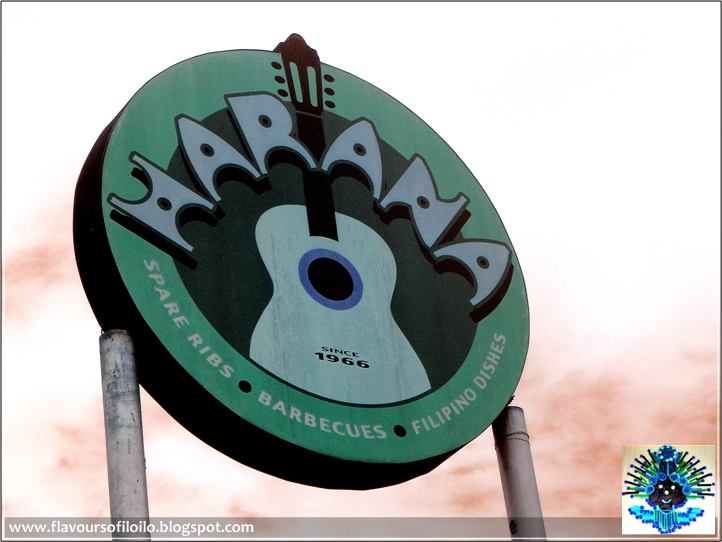

In [11]:
cv2.imread('/content/PaddleOCR/doc/imgs_en/img623.jpg')   #原图展示

Rotation Angle: 60.67952412241925
Rotation Angle: 45.0
Rotation Angle: -64.98310652189998
Rotation Angle: 9.926245506651705
Rotation Angle: 11.309932474020213
Rotation Angle: -35.45547443444187
Rotation Angle: 15.720927785822772
Rotation Angle: 0.6958659395087939


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
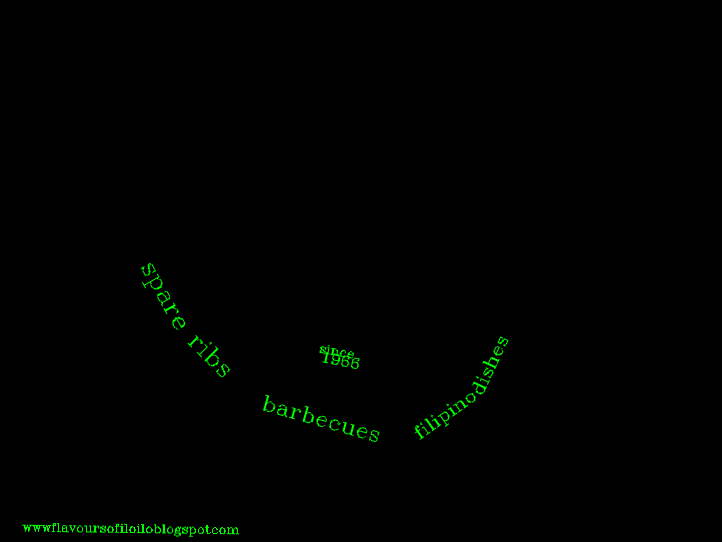

In [10]:
result_image = draw_e2e_res(points, strs, '/content/PaddleOCR/doc/imgs_en/img623.jpg')
result_image

## 第二个例子

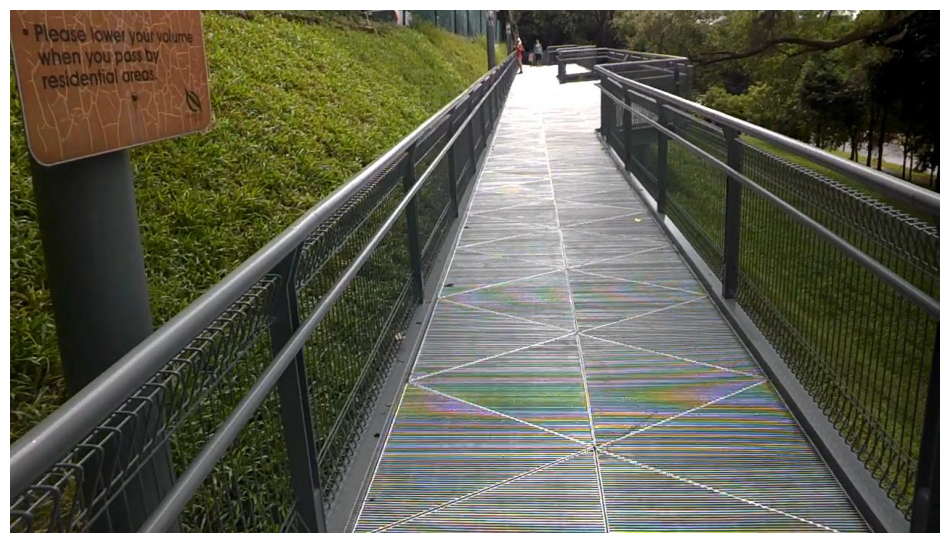

In [14]:
plt.show()
#%%
ORIGIN = cv2.imread('/content/PaddleOCR/doc/imgs_en/img_10.jpg')

ORIGIN = cv2.cvtColor(ORIGIN, cv2.COLOR_BGR2RGB)

# 显示图像
plt.figure(figsize=(12, 8))
plt.imshow(ORIGIN)
plt.axis('off')  # 隐藏坐标轴
plt.show()

[2024/11/03 06:39:47] ppocr WARNING: The first GPU is used for inference by default, GPU ID: 0
Rotation Angle: 0.0
Rotation Angle: 1.9749340108819766
Rotation Angle: -6.009005957494525
Rotation Angle: -1.0230301886678357
Rotation Angle: -4.398705354995532
Rotation Angle: -1.709814044141531
Rotation Angle: -5.9468630539735
Rotation Angle: -5.339236803737584
Rotation Angle: -6.7098368077569335


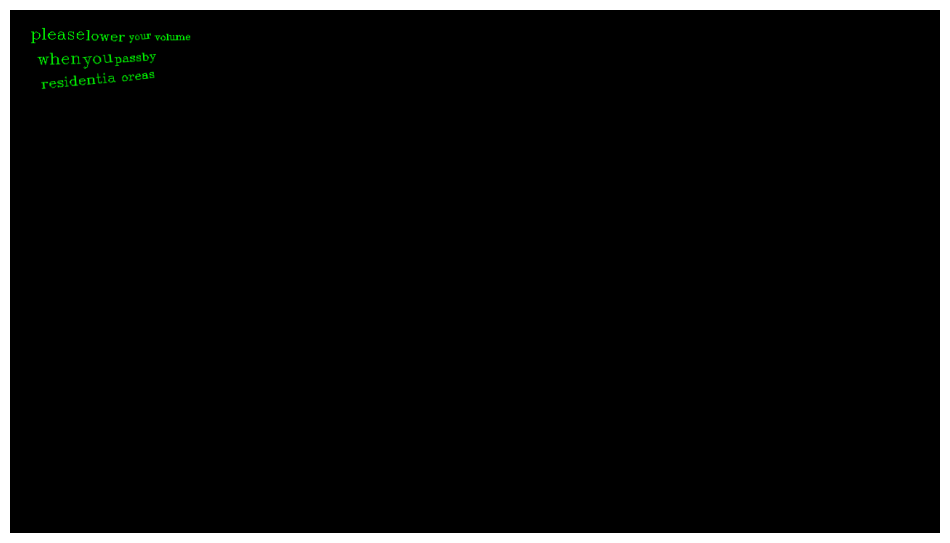

In [12]:
points, strs = OCR_E2E('/content/PaddleOCR/doc/imgs_en/img_10.jpg')
result_image = draw_e2e_res(points, strs, '/content/PaddleOCR/doc/imgs_en/img_10.jpg')
import matplotlib.pyplot as plt

result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

# 显示图像
plt.figure(figsize=(12, 8))
plt.imshow(result_image_rgb)
plt.axis('off')  # 隐藏坐标轴
plt.show()